# AlphaFold 3 PG fragments experimentation

Playing around with providing PG fragments as ligands to AF3.

In [1]:
import json
import os
from pathlib import Path
import random
import subprocess
import tempfile

from Bio import SeqIO
from rdkit import Chem
from rdkit.Chem.rdmolfiles import MolFromPDBFile, MolFromSmiles
from rdkit.Chem import AllChem
from rdkit.Chem.AllChem import Compute2DCoords, EmbedMolecule, UFFOptimizeMolecule
from rdkit.Chem import Draw
from rdkit.Chem.rdchem import BondType
import gemmi
from IPython.display import display

cwd = os.getcwd()
if cwd.endswith('notebook/PG'):
    os.chdir('../..')
    cwd = os.getcwd()

In [3]:
data_folder = Path('./data/')
assert data_folder.is_dir()

In [6]:
def gen_model_seeds(n):
    return [int(random.uniform(1, 100)) for _ in range(n)]

## Load & display PG fragment

PG fragment extracted from [7Q4T](https://www.rcsb.org/structure/7Q4T) – "Structure of the Pseudomonas aeruginosa bacteriophage JG004 endolysin Pae87 bound to a peptidoglycan fragment"

It is made of two glycans, GlcNAC and MurNAC, and one peptide stem from the cell wall of _P. aeruginosa_.

In [43]:
pdb_file = data_folder / 'AF3' / '7q4t_PG_fragment.pdb'
mol = MolFromPDBFile(pdb_file.resolve().as_posix())
Compute2DCoords(mol)
smiles = Chem.MolToSmiles(mol)
smiles

'CC(O)N[C@@H]1[C@@H](O[C@H](C)C(O)N[C@@H](C)C(=O)N[C@H](CCC(O)O)C(O)O)[C@H](O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2NC(C)O)[C@@H](CO)O[C@@H]1O'

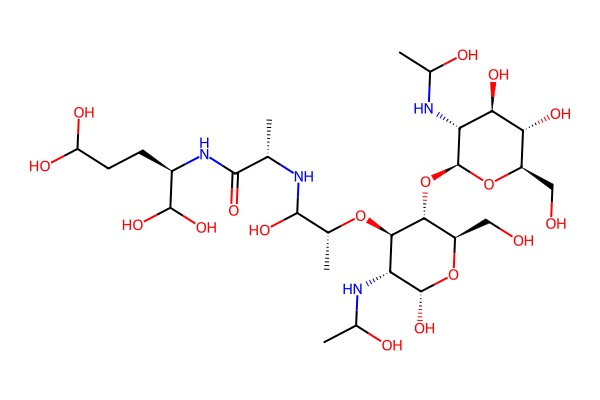

In [44]:
img = Draw.MolToImage(mol, size=(600, 400), dpi=300)
display(img)

## Load deacetylated version

In [45]:
pdb_file_deac = data_folder / 'AF3' / '7q4t_PG_fragment_deacetylated.pdb'
mol_deac = MolFromPDBFile(pdb_file_deac.resolve().as_posix())
Compute2DCoords(mol_deac)
smiles_deac = Chem.MolToSmiles(mol_deac)
smiles_deac

'C[C@H](NC(O)[C@@H](C)O[C@@H]1[C@@H]([NH3+])[C@@H](O)O[C@H](CO)[C@H]1O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1[NH3+])C(=O)N[C@H](CCC(O)O)C(O)O'

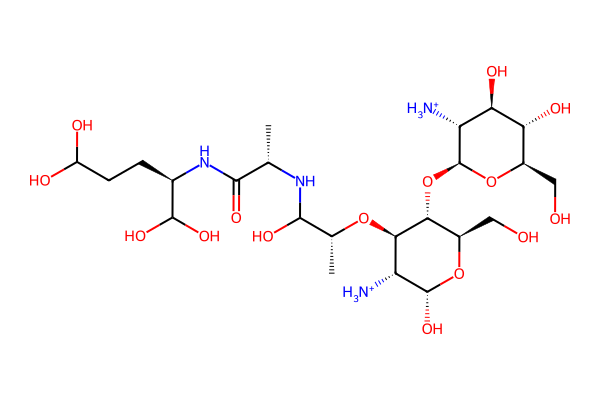

In [46]:
img_deac = Draw.MolToImage(mol_deac, size=(600, 400), dpi=300)
display(img_deac)

## Make AF compatible JSON files

Spec: https://github.com/google-deepmind/alphafold3/blob/main/docs/input.md

We'll load the sequence form the Human Lysozyme protein ([P61626](https://www.uniprot.org/uniprotkb/P61626/entry)).

In [56]:
seq_record = list(SeqIO.parse(data_folder / 'AF3' / 'Human_Lysozyme_P61626.fasta', 'fasta'))[0]

lysozyme_sequence = {
    'protein': {
        'id': 'A',
        'sequence': str(seq_record.seq).upper()
    },
}

In [57]:
pg_acetylated_sequence = {
    'ligand': {
        'id': 'B',
        'smiles': smiles,
    }
}
pg_deacetylated_sequence = {
    'ligand': {
        'id': 'B',
        'smiles': smiles_deac,
    }
}

In [ ]:
data_acetylated = {
    'name': 'LYZ_PG_acetylated',
    'sequences': [
        lysozyme_sequence,
        pg_acetylated_sequence,
    ],
    'modelSeeds': gen_model_seeds(3),
    'dialect': 'alphafold3',
    'version': 1,
}
data_deacetylated = {
    'name': 'LYZ_PG_deacetylated',
    'sequences': [
        lysozyme_sequence,
        pg_deacetylated_sequence,
    ],
    'modelSeeds': gen_model_seeds(3),
    'dialect': 'alphafold3',
    'version': 1,
}

In [59]:
with (data_folder / 'AF3' / 'LYZ_PG_acetylated.json').open('w') as f_out:
    json.dump(
        data_acetylated, 
        f_out,
        indent=True,
    )
with (data_folder / 'AF3' / 'LYZ_PG_deacetylated.json').open('w') as f_out:
    json.dump(
        data_deacetylated, 
        f_out,
        indent=True,
    )

## PG hexamuropeptide

From https://www.rcsb.org/structure/2mtz

In [7]:
PG_hexamuropeptide_file = data_folder / 'AF3' / 'PG_hexamuropeptide.pdb'
PG_hexamuropeptide_mol = MolFromPDBFile(PG_hexamuropeptide_file.resolve().as_posix())
#PG_hexamuropeptide_mol = Chem.AddHs(PG_hexamuropeptide_mol)
#EmbedMolecule(PG_hexamuropeptide_mol)
UFFOptimizeMolecule(PG_hexamuropeptide_mol)
#PG_hexamuropeptide_mol = Chem.AddHs(PG_hexamuropeptide_mol)
PG_hexamuropeptide_SMILES = Chem.MolToSmiles(PG_hexamuropeptide_mol)

[11:07:40] Molecule does not have explicit Hs. Consider calling AddHs()


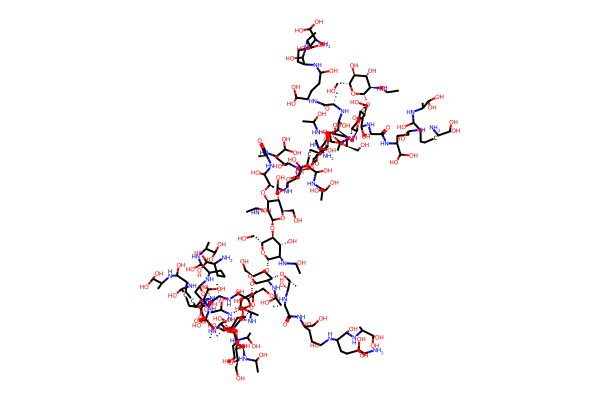

In [8]:
img = Draw.MolToImage(PG_hexamuropeptide_mol, size=(600, 400), dpi=300)
display(img)

In [24]:
# SMARTS for sugar-like substructures
sugar_smarts = "[C;R]1-[C;R]-[C;R]-[C;R]-[C;R]-[O;R]1"
sugar_matches = PG_hexamuropeptide_mol.GetSubstructMatches(Chem.MolFromSmarts(sugar_smarts))
len(sugar_matches)

12

In [25]:
# Detect peptide bonds (amide linkages)
peptide_smarts = "C(=O)-N"
peptide_matches = PG_hexamuropeptide_mol.GetSubstructMatches(Chem.MolFromSmarts(peptide_smarts))
len(peptide_matches)

6

## Generate CCD mmCIF file

In [119]:
def generate_ccd_from_mol(mol : Chem.Mol, ligand_name : str) -> str:
    """
    Generate a user-provided CCD file for AlphaFold 3 using RDKit for parsing
    and Gemmi for writing the mmCIF format.
    """
    # Generate 3D coordinates if missing
    try:
        mol.GetConformer()
    except ValueError:
        print("No conformer found. Generating 3D coordinates...")
        params = AllChem.ETKDGv3()
        params.randomSeed = 42
        AllChem.EmbedMolecule(mol, params)
        AllChem.UFFOptimizeMolecule(mol)

    # Extract atom and bond information
    atoms = []
    bonds = []
    formula = Chem.rdMolDescriptors.CalcMolFormula(mol)
    molecular_weight = Chem.rdMolDescriptors.CalcExactMolWt(mol)

    for atom in mol.GetAtoms():
        coords = mol.GetConformer().GetAtomPosition(atom.GetIdx())
        atoms.append({
            "id": atom.GetIdx(),
            "element": atom.GetSymbol(),
            "charge": atom.GetFormalCharge(),
            "coords": coords,
            "leaving": "N"  # Default: not a leaving atom
        })

    bond_type_mapping = {
        BondType.SINGLE: ("SING", "N"),
        BondType.DOUBLE: ("DOUB", "N"),
        BondType.TRIPLE: ("TRIP", "N"),
        BondType.AROMATIC: ("AROM", "Y"),
    }

    for bond in mol.GetBonds():
        bond_type, aromatic_flag = bond_type_mapping.get(bond.GetBondType(), ("SING", "N"))
        bonds.append({
            "atom1": bond.GetBeginAtomIdx(),
            "atom2": bond.GetEndAtomIdx(),
            "order": bond_type,
            "aromatic": aromatic_flag
        })

    # Create the mmCIF document
    doc = gemmi.cif.Document()
    block = doc.add_new_block(f"{ligand_name}")

    # Add _chem_comp metadata
    block.set_pair('_chem_comp.id', ligand_name)
    block.set_pair('_chem_comp.name', ligand_name)
    block.set_pair('_chem_comp.type', 'non-polymer')
    block.set_pair('_chem_comp.formula', formula)
    block.set_pair('_chem_comp.formula_weight', f"{molecular_weight:.3f}")
    block.set_pair('_chem_comp.mon_nstd_parent_comp_id', '?')
    block.set_pair('_chem_comp.pdbx_synonyms', '?')

    # Add atoms to _chem_comp_atom
    atom_loop = block.init_loop('_chem_comp_atom.', [
        'comp_id', 'atom_id', 'type_symbol', 'charge',
        'pdbx_model_Cartn_x_ideal', 'pdbx_model_Cartn_y_ideal', 'pdbx_model_Cartn_z_ideal', 'pdbx_leaving_atom_flag'
    ])
    for atom in atoms:
        atom_loop.add_row([
            ligand_name, f"{atom['element']}{atom['id'] + 1}", atom['element'], str(atom['charge']),
            f"{atom['coords'].x:.3f}", f"{atom['coords'].y:.3f}", f"{atom['coords'].z:.3f}", atom['leaving']
        ])

    # Add bonds to _chem_comp_bond
    bond_loop = block.init_loop('_chem_comp_bond.', [
        'comp_id', 'atom_id_1', 'atom_id_2', 'value_order', 'pdbx_aromatic_flag'
    ])
    for bond in bonds:
        atom1 = f"{atoms[bond['atom1']]['element']}{bond['atom1'] + 1}"
        atom2 = f"{atoms[bond['atom2']]['element']}{bond['atom2'] + 1}"
        bond_loop.add_row([ligand_name, atom1, atom2, bond['order'], bond['aromatic']])

    # Write the mmCIF file
    #doc.write_file(output_ccd_file)
    #print(f"CCD mmCIF file saved to: {output_ccd_file}")

    # Convert the mmCIF document to a string
    ccd_content = doc.as_string()
    # Replace newline characters for JSON compatibility
    #ccd_content = ccd_content.replace('\n', '\\n')

    return ccd_content


def generate_ccd_from_pdb(input_pdb : Path, ligand_name : str) -> str:
    mol = Chem.MolFromPDBFile(input_pdb, removeHs=False)
    if mol is None:
        raise ValueError("Failed to parse the input PDB file. Ensure it contains valid ligand information.")
    
    return generate_ccd_from_mol(mol, ligand_name)


generate_ccd = generate_ccd_from_pdb  # compatibility


def generate_ccd_from_smiles(smiles : str, ligand_name : str) -> str:
    mol = MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Failed to parse the input SMILES. Ensure it contains valid ligand information.")
    
    return generate_ccd_from_mol(mol, ligand_name)

In [112]:
# Example usage:
input_pdb = (data_folder / 'AF3' / 'PG_hexamuropeptide.pdb').as_posix()
ligand_name = "LIG-PG"

pg_hexamuropeptide_ccd = generate_ccd(input_pdb, ligand_name)
pg_hexamuropeptide_ccd

[15:26:43] Molecule does not have explicit Hs. Consider calling AddHs()


'data_LIG-PG\n_chem_comp.id LIG-PG\n_chem_comp.name LIG-PG\n_chem_comp.type non-polymer\n_chem_comp.formula C222H452N42O121\n_chem_comp.formula_weight 5643.051\n_chem_comp.mon_nstd_parent_comp_id ?\n_chem_comp.pdbx_synonyms ?\n\nloop_\n_chem_comp_atom.comp_id\n_chem_comp_atom.atom_id\n_chem_comp_atom.type_symbol\n_chem_comp_atom.charge\n_chem_comp_atom.pdbx_model_Cartn_x_ideal\n_chem_comp_atom.pdbx_model_Cartn_y_ideal\n_chem_comp_atom.pdbx_model_Cartn_z_ideal\n_chem_comp_atom.pdbx_leaving_atom_flag\nLIG-PG N1 N 0 17.846 10.164 -6.601 N\nLIG-PG C2 C 0 18.171 8.924 -7.320 N\nLIG-PG C3 C 0 19.597 8.910 -7.706 N\nLIG-PG O4 O 0 20.380 9.801 -7.220 N\nLIG-PG C5 C 0 17.301 8.801 -8.585 N\nLIG-PG N6 N 0 20.170 7.733 -8.266 N\nLIG-PG C7 C 0 21.530 7.720 -8.841 N\nLIG-PG C8 C 0 21.948 6.298 -9.246 N\nLIG-PG O9 O 0 23.350 6.183 -9.176 N\nLIG-PG C10 C 0 21.567 8.688 -10.001 N\nLIG-PG C11 C 0 22.980 8.849 -10.507 N\nLIG-PG C12 C 0 22.972 9.278 -11.957 N\nLIG-PG O13 O 0 22.259 8.355 -12.744 N\nLIG-P

## PG fragment from Streptococcus pneumoniae

https://www.rcsb.org/structure/5ctv

[13:07:56] Molecule does not have explicit Hs. Consider calling AddHs()


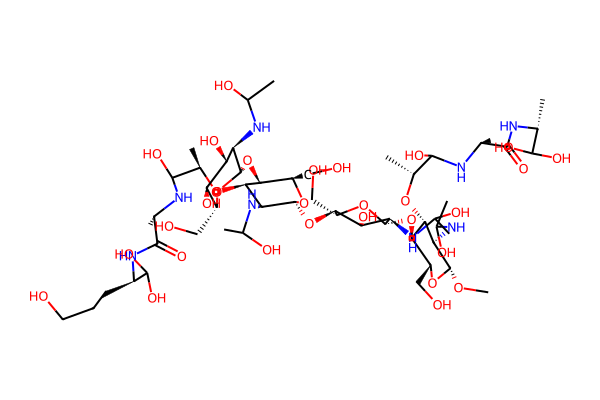

In [23]:
PG_fragment_5ctv_path = data_folder / 'AF3' / '5ctv_PG_fragment.pdb'
PG_fragment_5ctv_mol = MolFromPDBFile(PG_fragment_5ctv_path.resolve().as_posix())
AllChem.UFFOptimizeMolecule(PG_fragment_5ctv_mol)
PG_fragment_5ctv_SMILES = Chem.MolToSmiles(PG_fragment_5ctv_mol, canonical=False)

img = Draw.MolToImage(PG_fragment_5ctv_mol, size=(600, 400), dpi=300)
display(img)

In [20]:
# SMARTS for sugar-like substructures
sugar_smarts = "[C;R]1-[C;R]-[C;R]-[C;R]-[C;R]-[O;R]1"
sugar_matches = PG_fragment_5ctv_mol.GetSubstructMatches(Chem.MolFromSmarts(sugar_smarts))
print("Sugar matches:", sugar_matches)

Sugar matches: ((25, 26, 27, 28, 29, 39), (45, 46, 47, 48, 49, 56), (59, 60, 61, 62, 63, 72), (77, 78, 79, 80, 81, 88))


In [19]:
# Detect peptide bonds (amide linkages)
peptide_smarts = "C(=O)-N"
peptide_matches = PG_fragment_5ctv_mol.GetSubstructMatches(Chem.MolFromSmarts(peptide_smarts))
print("Peptide matches:", peptide_matches)

Peptide matches: ((2, 3, 5), (16, 17, 19))


### CCD

In [56]:
PG_fragment_5ctv_ccd = generate_ccd(PG_fragment_5ctv_path, 'LIG-PG-5ctv')

[10:44:18] Molecule does not have explicit Hs. Consider calling AddHs()


LysM x3 from Lactococcus lactis:

In [57]:
lysM_fasta_path = data_folder / 'AF3' / 'LysM' / 'acmA_A2RHZ5_LysM_241_437.fasta'
lysM_record = list(SeqIO.parse(lysM_fasta_path, 'fasta'))[0]
lysM_sequence = {
    'protein': {
        'id': 'A',
        'sequence': str(lysM_record.seq).upper()
    },
}

LysM x1 from Streptococcus pneumoniae:

In [58]:
lysM_Strep_fasta_path = data_folder / 'AF3' / 'LysM' / 'A0A4J1R814_S_pneumoniae_LysM_266_312.fasta'
lysM_Strep_record = list(SeqIO.parse(lysM_Strep_fasta_path, 'fasta'))[0]
lysM_Strep_sequence = {
    'protein': {
        'id': 'A',
        'sequence': str(lysM_Strep_record.seq).upper()
    },
}

LysM x1 from B. subtilis:

In [64]:
lysM_Bacillus_fasta_path = data_folder / 'AF3' / 'LysM' / 'LysM_B_subtilis_O07532_27_70.fasta'
lysM_Bacillus_record = list(SeqIO.parse(lysM_Bacillus_fasta_path, 'fasta'))[0]
lysM_Bacillus_sequence = {
    'protein': {
        'id': 'A',
        'sequence': str(lysM_Bacillus_record.seq).upper()
    },
}

In [61]:
data_LysM_PG = {
    'name': 'LysM_PG',
    'sequences': [
        lysM_Strep_sequence,
        {
            'ligand': {
                'id': 'B',
                'ccdCodes': ['LIG-PG-5ctv'],
            }
        },
    ],
    'modelSeeds': gen_model_seeds(5),
    'userCCD': PG_fragment_5ctv_ccd,
    'dialect': 'alphafold3',
    'version': 1,
}

with (data_folder / 'AF3' / 'LysM' / 'LysM_A0A4J1R814_266_312_vs_PG_5ctv.json').open('w') as f_out:
    json.dump(
        data_LysM_PG, 
        f_out,
        indent=True,
    )

In [66]:
data_LysM_PG_ccd = {
    'name': 'LysM_PG',
    'sequences': [
        lysM_Bacillus_sequence,
        {
            'ligand': {
                'id': 'B',
                'ccdCodes': ['LIG-PG']
            }
        },
    ],
    'modelSeeds': gen_model_seeds(5),
    'dialect': 'alphafold3',
    'userCCD': pg_hexamuropeptide_ccd,
    'version': 1,
}

with (data_folder / 'AF3' / 'LysM' / 'LysM_B_subtilis_O07532_27_70_vs_PG_hexamuropeptide.json').open('w') as f_out:
    json.dump(
        data_LysM_PG_ccd, 
        f_out,
        indent=True,
    )

Notes on how AF3 processes ligand specified as user-provided CCD mmCIF data: https://github.com/google-deepmind/alphafold3/issues/212

### Halogranum salarium glucosaminidase J2ZJU5

In [73]:
h_salarium_J2ZJU5_path = data_folder / 'AF3' / 'H_salarium_PGH' / 'H_salarium_J2ZJU5.fasta'
h_salarium_J2ZJU5_records = SeqIO.to_dict(SeqIO.parse(h_salarium_J2ZJU5_path, 'fasta'))

h_salarium_J2ZJU5_glucosaminidase = {
    'protein': {
        'id': 'A',
        'sequence': str(h_salarium_J2ZJU5_records['H_salarium_J2ZJU5_Glucosaminidase_55_191'].seq).upper()
    },
}
h_salarium_J2ZJU5_PGB1_1 = {
    'protein': {
        'id': 'A',
        'sequence': str(h_salarium_J2ZJU5_records['H_salarium_J2ZJU5_PG_binding_1_204_260'].seq).upper()
    },
}
h_salarium_J2ZJU5_PGB1_2 = {
    'protein': {
        'id': 'A',
        'sequence': str(h_salarium_J2ZJU5_records['H_salarium_J2ZJU5_PG_binding_1_278_327'].seq).upper()
    },
}

In [76]:
PG_5ctv = {
    'ligand': {
        'id': 'B',
        'ccdCodes': ['LIG-PG-5ctv'],
    }
}

data_h_salarium_J2ZJU5_glucosaminidase_PG_5ctv = {
    'name': 'J2ZJU5_glucosaminidase_PG_5ctv',
    'sequences': [
        h_salarium_J2ZJU5_glucosaminidase,
        PG_5ctv,
    ],
    'modelSeeds': gen_model_seeds(5),
    'userCCD': PG_fragment_5ctv_ccd,
    'dialect': 'alphafold3',
    'version': 1,
}
with (data_folder / 'AF3' / 'H_salarium_PGH' / 'H_salarium_J2ZJU5_Glucosaminidase_55_191_vs_PG_5ctv.json').open('w') as f_out:
    json.dump(
        data_h_salarium_J2ZJU5_glucosaminidase_PG_5ctv, 
        f_out,
        indent=True,
    )

data_h_salarium_J2ZJU5_PGB1_1_PG_5ctv = {
    'name': 'J2ZJU5_PGB1_1_PG_5ctv',
    'sequences': [
        h_salarium_J2ZJU5_PGB1_1,
        PG_5ctv,
    ],
    'modelSeeds': gen_model_seeds(5),
    'userCCD': PG_fragment_5ctv_ccd,
    'dialect': 'alphafold3',
    'version': 1,
}
with (data_folder / 'AF3' / 'H_salarium_PGH' / 'H_salarium_J2ZJU5_PG_binding_1_204_260_vs_PG_5ctv.json').open('w') as f_out:
    json.dump(
        data_h_salarium_J2ZJU5_PGB1_1_PG_5ctv, 
        f_out,
        indent=True,
    )

data_h_salarium_J2ZJU5_PGB1_2_PG_5ctv = {
    'name': 'J2ZJU5_PGB1_2_PG_5ctv',
    'sequences': [
        h_salarium_J2ZJU5_PGB1_2,
        PG_5ctv,
    ],
    'modelSeeds': gen_model_seeds(5),
    'userCCD': PG_fragment_5ctv_ccd,
    'dialect': 'alphafold3',
    'version': 1,
}
with (data_folder / 'AF3' / 'H_salarium_PGH' / 'H_salarium_J2ZJU5_PG_binding_1_278_327_vs_PG_5ctv.json').open('w') as f_out:
    json.dump(
        data_h_salarium_J2ZJU5_PGB1_2_PG_5ctv, 
        f_out,
        indent=True,
    )

## Peptidoglycan fragments DB

Generated with https://github.com/jerickwan/PGN_MS2

[11:04:58] Molecule does not have explicit Hs. Consider calling AddHs()


-1


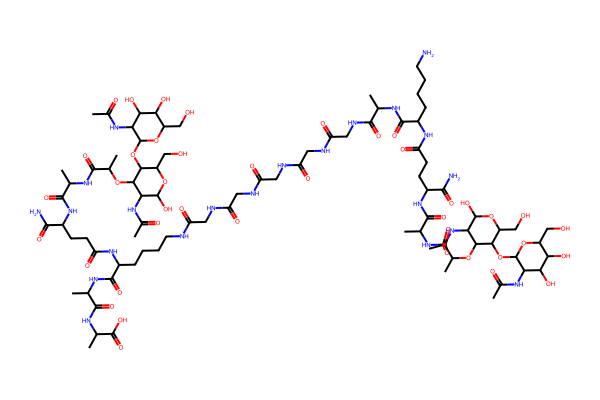

In [53]:
example_smiles = 'CC(=O)NC1C(OC2C(CO)OC(O)C(NC(C)=O)C2OC(C)C(=O)NC(C)C(=O)NC(CCC(=O)NC(CCCCN)C(=O)NC(C)C(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCCCCC(NC(=O)CCC(NC(=O)C(C)NC(=O)C(C)OC2C(NC(C)=O)C(O)OC(CO)C2OC2OC(CO)C(O)C(O)C2NC(C)=O)C(N)=O)C(=O)NC(C)C(=O)NC(C)C(=O)O)C(N)=O)OC(CO)C(O)C1O'
pgn = MolFromSmiles(example_smiles)
Chem.SanitizeMol(pgn)
params = AllChem.ETKDGv3()
params.randomSeed = 42
params.maxAttempts = 100
conformer_id = AllChem.EmbedMolecule(pgn, params)
print(conformer_id)
#Compute2DCoords(pgn)
pgn_img = Draw.MolToImage(pgn, size=(600, 400), dpi=300)
display(pgn_img)

RDKit struggles to come up with a 3D conformation for this larger molecule. 

Here is what `obabel` comes up with:

In [94]:
def run_obabel_gen3d(smiles : str, output_path : Path) -> Chem.Mol:
    output_path_str = output_path.resolve().as_posix()
    subprocess.run(
        [
            'obabel', '-:' + smiles, 
            '-O', output_path_str, 
            '--gen3d', 
            '--best',
        ],
        check=True
    )
    return MolFromPDBFile(output_path_str)

1 molecule converted


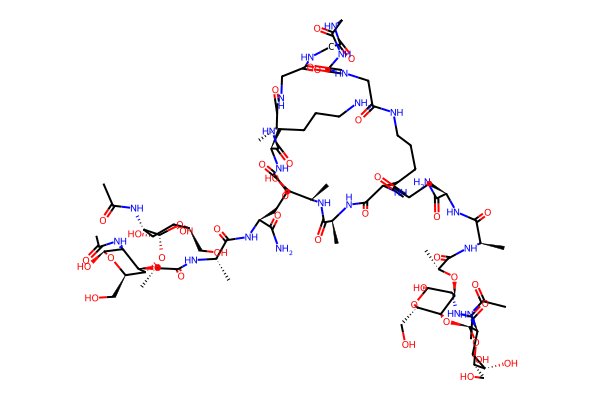

In [99]:
m = run_obabel_gen3d(example_smiles, Path('/Users/rs1521/Downloads/test.pdb'))
pgn_img = Draw.MolToImage(m, size=(600, 400), dpi=300)
display(pgn_img)

## Staphylococcus aureus peptidoglycan

### Canonical form

`GlcNAc.MurNAc--Ala.γ-isoGln.Lys.Ala.Ala[3--NH2--Gly.Gly.Gly.Gly.Gly]`

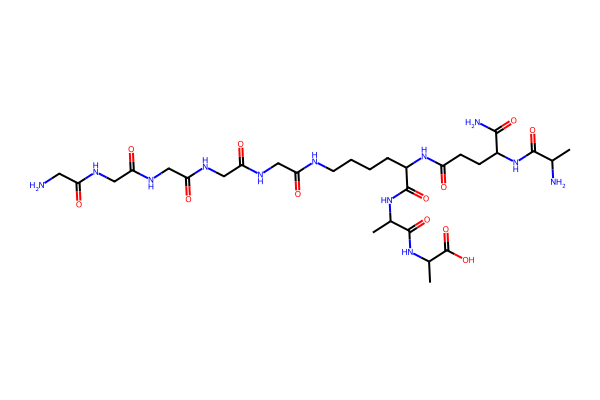

In [128]:
# S_aureus_smiles = (
#     'CC(=O)NC1C(OC2C(CO)OC(O)C(NC(C)=O)C2OC(C)C(=O)NC(C)C(=O)NC(CCC(=O)NC(CCCCNC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)CN)C(=O)NC(C)C(=O)NC(C)C(=O)O)C(N)=O)OC(CO)C(O)C1O'
# )
S_aureus_smiles = (
    'CC(N)C(=O)NC(CCC(=O)NC(CCCCNC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)CN)C(=O)NC(C)C(=O)NC(C)C(=O)O)C(N)=O'
)
S_aureus_pgn = MolFromSmiles(S_aureus_smiles)
Compute2DCoords(S_aureus_pgn)
pgn_img = Draw.MolToImage(S_aureus_pgn, size=(600, 400), dpi=300)
display(pgn_img)


[23:25:14] Molecule does not have explicit Hs. Consider calling AddHs()
[23:25:14] Molecule does not have explicit Hs. Consider calling AddHs()


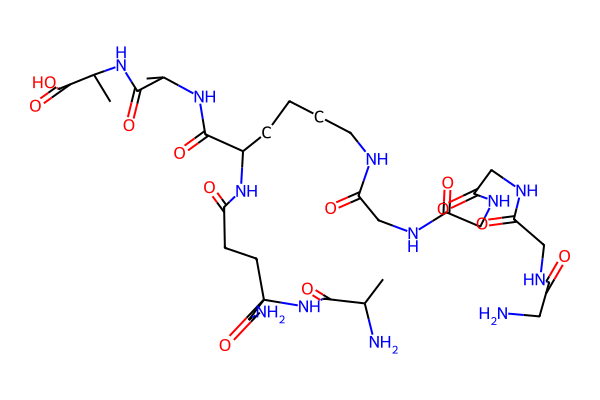

In [129]:
params = AllChem.ETKDGv3()
params.randomSeed = 42
conformer_id = AllChem.EmbedMolecule(S_aureus_pgn, params)
assert conformer_id != -1
AllChem.UFFOptimizeMolecule(S_aureus_pgn)
pgn_img = Draw.MolToImage(S_aureus_pgn, size=(600, 400), dpi=300)
display(pgn_img)

### Alternative bridge 1

`GlcNAc.MurNAc--Ala.γ-isoGln.Lys.Ala.Ala[3--NH2--Ala.Gly.Gly.Gly.Gly]`

First glycine of peptide bridge is replaced with an alanine residue.

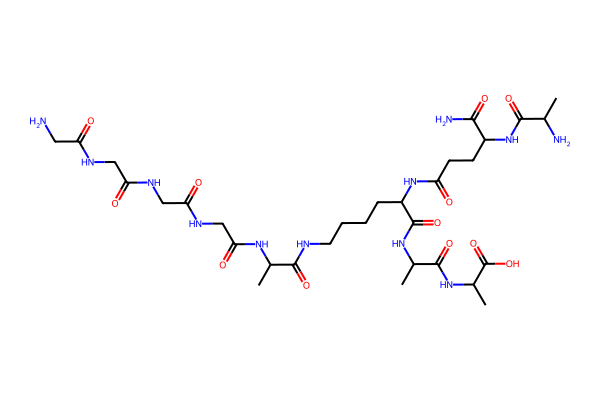

In [130]:
# S_aureus_smiles_alt1 = (
#     'CC(=O)NC1C(OC2C(CO)OC(O)C(NC(C)=O)C2OC(C)C(=O)NC(C)C(=O)NC(CCC(=O)NC(CCCCNC(=O)C(C)NC(=O)CNC(=O)CNC(=O)CNC(=O)CN)C(=O)NC(C)C(=O)NC(C)C(=O)O)C(N)=O)OC(CO)C(O)C1O'
# )
S_aureus_smiles_alt1 = (
    'CC(N)C(=O)NC(CCC(=O)NC(CCCCNC(=O)C(C)NC(=O)CNC(=O)CNC(=O)CNC(=O)CN)C(=O)NC(C)C(=O)NC(C)C(=O)O)C(N)=O'
)
S_aureus_pgn_alt1 = MolFromSmiles(S_aureus_smiles_alt1)
Compute2DCoords(S_aureus_pgn_alt1)
pgn_img = Draw.MolToImage(S_aureus_pgn_alt1, size=(600, 400), dpi=300)
display(pgn_img)

### Alternative bridge 2

`GlcNAc.MurNAc--Ala.γ-isoGln.Lys.Ala.Ala[3--NH2--Ser.Gly.Gly.Gly.Gly]`

First glycine of peptide bridge is replaced with a serine resiude.

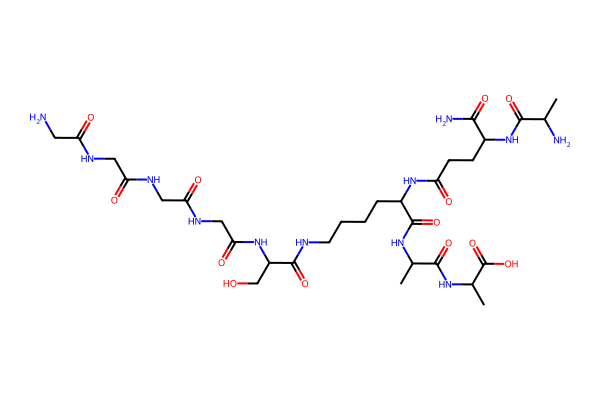

In [131]:
# S_aureus_smiles_alt2 = (
#     'CC(=O)NC1C(OC2C(CO)OC(O)C(NC(C)=O)C2OC(C)C(=O)NC(C)C(=O)NC(CCC(=O)NC(CCCCNC(=O)C(CO)NC(=O)CNC(=O)CNC(=O)CNC(=O)CN)C(=O)NC(C)C(=O)NC(C)C(=O)O)C(N)=O)OC(CO)C(O)C1O'
# )
S_aureus_smiles_alt2 = (
    'CC(N)C(=O)NC(CCC(=O)NC(CCCCNC(=O)C(CO)NC(=O)CNC(=O)CNC(=O)CNC(=O)CN)C(=O)NC(C)C(=O)NC(C)C(=O)O)C(N)=O'
)
S_aureus_pgn_alt2 = MolFromSmiles(S_aureus_smiles_alt2)
Compute2DCoords(S_aureus_pgn_alt2)
pgn_img = Draw.MolToImage(S_aureus_pgn_alt2, size=(600, 400), dpi=300)
display(pgn_img)

### AF3 inputs

In [132]:
pg_modelling_folder = Path(os.path.expanduser('~')) / 'Documents' / 'PG_modelling'

lysostaphin_path = pg_modelling_folder / 'S_aureus_lysostaphin.fasta'
lysostaphin_records = SeqIO.to_dict(SeqIO.parse(lysostaphin_path, 'fasta'))

lysostaphin_peptidase_m23 = {
    'protein': {
        'id': 'A',
        'sequence': str(lysostaphin_records['Lysostaphin_P10547_Peptiase_M23_279_364'].seq).upper()
    },
}
lysostaphin_sh3b = {
    'protein': {
        'id': 'A',
        'sequence': str(lysostaphin_records['Lysostaphin_P10547_SH3b_413_481'].seq).upper()
    },
}

In [133]:
pg_canonical_seq = {
    'ligand': {
        'id': 'B',
        'smiles': S_aureus_smiles,
    }
}
pg_alt1_seq = {
    'ligand': {
        'id': 'B',
        'smiles': S_aureus_smiles_alt1,
    }
}
pg_alt2_seq = {
    'ligand': {
        'id': 'B',
        'smiles': S_aureus_smiles_alt2,
    }
}
zn_ion_seq = {
    'ligand': {
        'id': 'C',
        'smiles': '[Zn+2]',
    }
}

In [134]:
pg_canonical_seq_ccd = {
    'ligand': {
        'id': 'B',
        'ccdCodes': ['LIG-PG-CANONICAL'],
    }
}
pg_canonical_ccd_data = generate_ccd_from_smiles(S_aureus_smiles, 'LIG-PG-CANONICAL')

pg_alt1_seq_ccd = {
    'ligand': {
        'id': 'B',
        'ccdCodes': ['LIG-PG-ALT1'],
    }
}
pg_alt1_ccd_data = generate_ccd_from_smiles(S_aureus_smiles_alt1, 'LIG-PG-ALT1')

pg_alt2_seq_ccd = {
    'ligand': {
        'id': 'B',
        'ccdCodes': ['LIG-PG-ALT2'],
    }
}
pg_alt2_ccd_data = generate_ccd_from_smiles(S_aureus_smiles_alt2, 'LIG-PG-ALT2')

No conformer found. Generating 3D coordinates...
No conformer found. Generating 3D coordinates...
No conformer found. Generating 3D coordinates...


[23:27:56] Molecule does not have explicit Hs. Consider calling AddHs()
[23:27:56] Molecule does not have explicit Hs. Consider calling AddHs()
[23:27:56] Molecule does not have explicit Hs. Consider calling AddHs()
[23:27:56] Molecule does not have explicit Hs. Consider calling AddHs()
[23:27:56] Molecule does not have explicit Hs. Consider calling AddHs()
[23:27:56] Molecule does not have explicit Hs. Consider calling AddHs()


In [139]:
lysostaphin_domains = [
    ('M23', lysostaphin_peptidase_m23),
    ('SH3b', lysostaphin_sh3b),
]
ligands = [
    ('PG_canonical', pg_canonical_seq, pg_canonical_ccd_data),
    ('PG_alt1', pg_alt1_seq, pg_alt1_ccd_data),
    ('PG_alt2', pg_alt2_seq, pg_alt2_ccd_data),
]
ions_def = {
    #'M23': [zn_ion_seq],
}
for domain_name, domain_seq in lysostaphin_domains:
    for ligand_name, ligand_seq, ccd_data in ligands:
        name = f'Lysostaphin_{domain_name}_vs_{ligand_name}'

        ions = ions_def.get(domain_name, [])
        sequences = [
            domain_seq,
            ligand_seq,
        ]
        sequences += ions

        data = {
            'name': name,
            'sequences': sequences,
            #'userCCD': ccd_data,
            'modelSeeds': gen_model_seeds(3),
            'dialect': 'alphafold3',
            'version': 1,
        }
        with (pg_modelling_folder / f'{name}.json').open('w') as f_out:
            json.dump(
                data, 
                f_out,
                indent=True,
            )

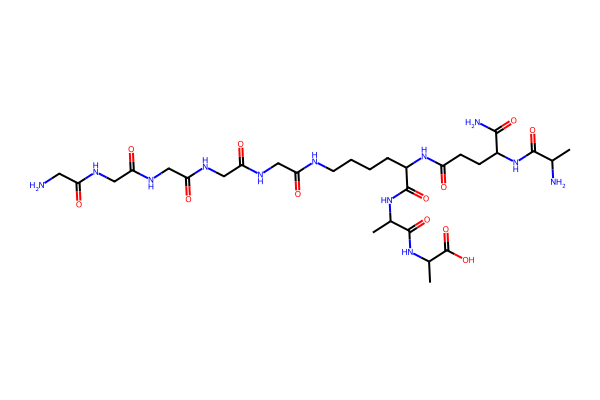

In [127]:
m = MolFromSmiles(
    'CC(N)C(=O)NC(CCC(=O)NC(CCCCNC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)CN)C(=O)NC(C)C(=O)NC(C)C(=O)O)C(N)=O'
)
Compute2DCoords(m)
pgn_img = Draw.MolToImage(m, size=(600, 400), dpi=300)
display(pgn_img)

True


[23:19:54] Molecule does not have explicit Hs. Consider calling AddHs()
[23:19:54] Molecule does not have explicit Hs. Consider calling AddHs()


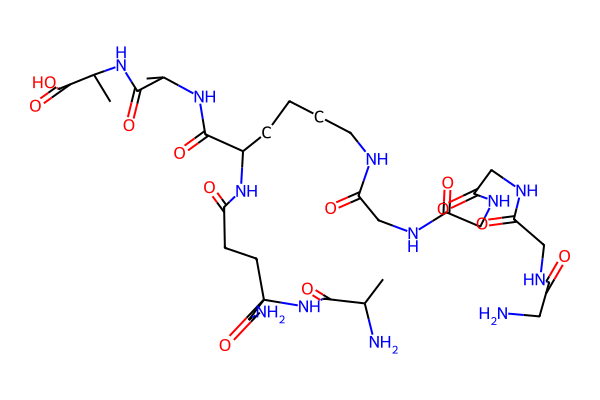

In [124]:
m = MolFromSmiles(
    'CC(N)C(=O)NC(CCC(=O)NC(CCCCNC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)CN)C(=O)NC(C)C(=O)NC(C)C(=O)O)C(N)=O'
)
params = AllChem.ETKDGv3()
params.randomSeed = 42
conformer_id = AllChem.EmbedMolecule(m, params)
print(m.GetConformer(conformer_id).Is3D())
AllChem.UFFOptimizeMolecule(m)
pgn_img = Draw.MolToImage(m, size=(600, 400), dpi=300)
display(pgn_img)

1 molecule converted


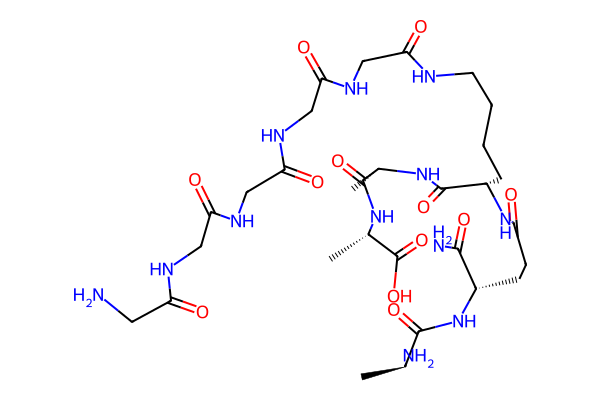

In [126]:
with tempfile.NamedTemporaryFile(suffix='.pdb') as f:
    m = run_obabel_gen3d(
        'CC(N)C(=O)NC(CCC(=O)NC(CCCCNC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)CN)C(=O)NC(C)C(=O)NC(C)C(=O)O)C(N)=O', 
        Path(f.name)
    )

pgn_img = Draw.MolToImage(m, size=(600, 400), dpi=300)
display(pgn_img)